# Libraries

In [1]:
# Load libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import textwrap
import time

from nltk.corpus import words, stopwords
from nltk.tokenize import word_tokenize
from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import label_binarize
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn import metrics
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_auc_score
)
from sklearn.metrics import roc_curve, auc
from sklearn.svm import SVC
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from imblearn.metrics import classification_report_imbalanced
from datetime import datetime

import joblib

# Download NLTK resources
import nltk
nltk.download('words')
nltk.download('punkt')


[nltk_data] Downloading package words to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Importing cleaned datasets

In [2]:
# Load cleaned dataset
df = pd.read_csv(r"Final_Data_Engineering_Data.csv")

# Display the first 5 entries of the DataFrame
df.head(5)

,Unnamed: 0,Sentiment,clean_text,translated_text,tokens,Mood
0,0,Neutral,our innovation lab officially open click learn...,innovation officially open click learn tech sc...,"['innovation', 'officially', 'open', 'click', ...",0
1,1,Neutral,now open aws asia pacific seoul region via are...,open pacific region,"['open', 'pacific', 'region']",0
2,2,Neutral,a beginners guide scaling million users amazon...,guide scaling million,"['guide', 'scaling', 'million']",0
3,3,Neutral,bridging aws azure environment via vpn via are...,bridging azure environment,"['bridging', 'azure', 'environment']",0
4,4,Neutral,elk aws elasticsearch service elasticbeanstalk...,service,['service'],0


This distribution is imbalanced for modeling because the classes (moods) are not represented equally.
- The 'Neutral' class significantly outweighs both the 'Positive' and 'Negative' classes. The imbalance is particularly notable between 'Neutral' and 'Negative', where 'Neutral' is about 12 times more frequent than 'Negative'.
- Such imbalances can lead to biased models that favor the majority class ('Neutral') and may perform poorly on the minority classes ('Positive' and 'Negative'). This is because the model might learn to predict the majority class more often, as it minimizes overall error but may fail to capture the patterns in the minority classes.
- Traditional performance metrics like accuracy can be misleading in imbalanced datasets, as a model predicting only the majority class could still achieve high accuracy.

To address this imbalance, techniques such as resampling (e.g. SMOTE), class weighting, or using specialized metrics (e.g. Precision, Recall,F1 score) should be considered to improve model performance across all classes.

In [3]:
df['Mood'].value_counts()

Mood
0    62006
1    26240
2     5214
Name: count, dtype: int64

C:\Users\admin\AppData\Local\Temp\ipykernel_29268\1427554676.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', len(mood_counts))


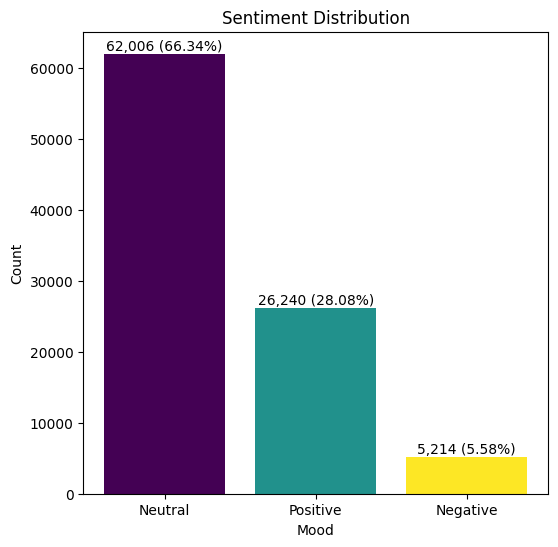

In [4]:
# Count the occurrences of each mood
mood_counts = df['Mood'].value_counts().sort_index()

# Map the mood numbers to labels
mood_labels = {0: 'Neutral', 1: 'Positive', 2: 'Negative'}
mood_counts.index = mood_counts.index.map(mood_labels)

# Define colors using 'viridis' colormap
cmap = cm.get_cmap('viridis', len(mood_counts))
colors = [cmap(i) for i in range(len(mood_counts))]

# Calculate percentages
total_count = mood_counts.sum()
mood_percentages = (mood_counts / total_count) * 100

# Create a bar plot
plt.figure(figsize=(6, 6))
bars = plt.bar(mood_counts.index, mood_counts.values, color=colors)
plt.title('Sentiment Distribution')
plt.xlabel('Mood')
plt.ylabel('Count')

# Add value annotations on the bars with comma formatting and percentages
for bar, percentage in zip(bars, mood_percentages):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2., height, f'{int(height):,} ({percentage:.2f}%)',
             ha='center', va='bottom')

plt.show()

# Splitting the data to training data and test data
- Set stratify=y in train_test_split, it ensures that the class distribution in the training and testing sets is the same as in the original dataset. For example, if your original dataset has 66% 'Neutral', 27% 'Positive', and 5% 'Negative' samples, the training and testing sets will also have approximately the same proportions of these classes.  This helps to ensure that the model is trained and tested on representative samples of the data, avoiding biases that could arise from having different class distributions in the training and testing sets. Avoiding biases means preventing the situation where the model might perform well on some classes but poorly on others due to imbalanced representation in the training or testing data.

In [5]:
X = df['translated_text']
y = df['Mood']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Display shapes of the resulting datasets
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')


X_train shape: (74768,)
X_test shape: (18692,)
y_train shape: (74768,)
y_test shape: (18692,)


In [6]:
# Combine X_test and y_test into a DataFrame
test_df = pd.DataFrame({'translated_text': X_test, 'Mood': y_test})

# Save the DataFrame to a CSV file
test_df.to_csv('test_dataset.csv', index=False)

# Model Performance For Imbalanced Data

Execution time: 206.18 s

Random Forest Results:
Accuracy: 0.9428
Precision: 0.9423
Recall: 0.9428
F1 Score: 0.9416
ROC AUC Score: 0.9750
              precision    recall  f1-score   support

           0       0.95      0.98      0.96     12401
           1       0.93      0.91      0.92      5248
           2       0.92      0.71      0.80      1043

    accuracy                           0.94     18692
   macro avg       0.93      0.86      0.89     18692
weighted avg       0.94      0.94      0.94     18692



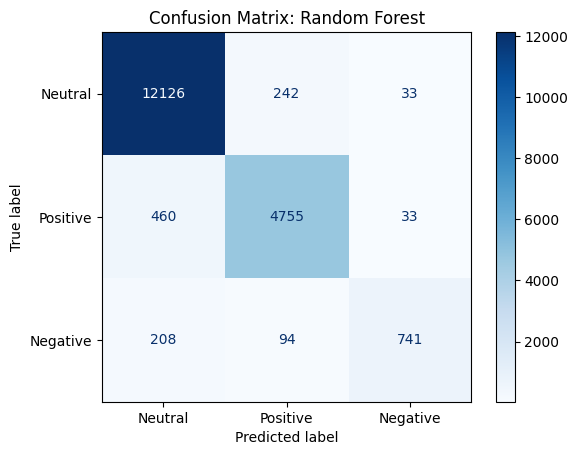

c:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Execution time: 12.65 s

Logistic Regression Results:
Accuracy: 0.8748
Precision: 0.8897
Recall: 0.8748
F1 Score: 0.8795
ROC AUC Score: 0.9526
              precision    recall  f1-score   support

           0       0.95      0.89      0.91     12401
           1       0.83      0.86      0.84      5248
           2       0.52      0.83      0.64      1043

    accuracy                           0.87     18692
   macro avg       0.77      0.86      0.80     18692
weighted avg       0.89      0.87      0.88     18692



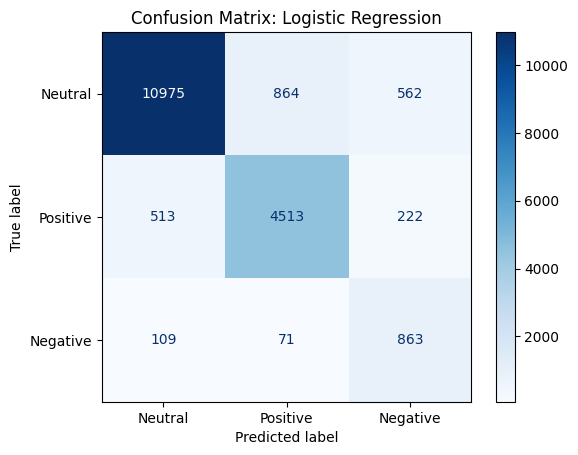

Execution time: 30.42 s

XGBoost Results:
Accuracy: 0.8898
Precision: 0.8928
Recall: 0.8898
F1 Score: 0.8834
ROC AUC Score: 0.9425
              precision    recall  f1-score   support

           0       0.88      0.98      0.93     12401
           1       0.92      0.77      0.84      5248
           2       0.91      0.46      0.61      1043

    accuracy                           0.89     18692
   macro avg       0.90      0.74      0.79     18692
weighted avg       0.89      0.89      0.88     18692



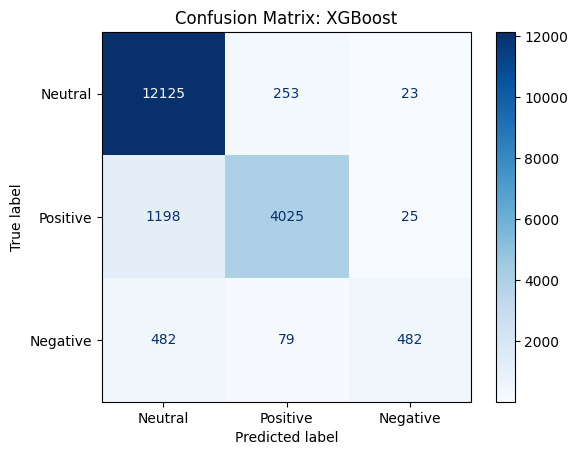

In [7]:
display_labels = ['Neutral', 'Positive', 'Negative']
X_train = X_train.fillna('')  
X_test = X_test.fillna('')  

models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(multi_class='multinomial', max_iter=500, class_weight='balanced',random_state=42),
    "XGBoost": XGBClassifier(objective='multi:softmax', num_class=3,random_state=42)
}

# Train, predict, and evaluate each model
for model_name, model in models.items():
    # Define the pipeline with TfidfVectorizer and the model
    pipeline = Pipeline([
        ('vectorizer', TfidfVectorizer()),  # Convert text to numerical features
        ('classifier', model)
    ])

    time_start = time.time()
    pipeline.fit(X_train, y_train)  # Fit the pipeline on training data
    y_pred = pipeline.predict(X_test)  # Predict on test data
    end_time = time.time() 
    execution_time = end_time - time_start
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_test, pipeline.predict_proba(X_test), multi_class='ovr')

    print("Training accuracy Score: ", model.score(X_train, y_train))
    print("Testing accuracy Score: ", accuracy)

    print(f"Execution time: {execution_time:.2f} s")    
    print(f"\n{model_name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC Score: {roc_auc:.4f}")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix: {model_name}")
    plt.show()


# How SMOTE (Synthetic Minority Over-sampling Technique) in our dataset:
- The number of examples for each mood is not equal. 'Neutral' has a lot more examples compared to 'Positive' and 'Negative'.
- When you train a machine learning model on this imbalanced data, the model can become biased. This means it might not learn to recognize 'Positive' and 'Negative' moods very well because it sees 'Neutral' much more often.
- SMOTE helps by creating new examples of the less common moods ('Positive' and 'Negative') to balance things out. It looks at the existing 'Positive' and 'Negative' examples and creates new, similar ones by mixing them together.
- By adding these new, synthetic examples to your dataset, SMOTE makes sure that each mood has roughly the same number of examples. This helps the machine learning model learn to recognize all moods equally well.
- synthetic example refers to a new, artificial data point that is generated to balance the dataset. 
- How it generate new data points: For each example in the minority class, SMOTE selects one or more of its nearest neighbors (other similar examples in the minority class).



In [8]:
# Applying tf idf to training and test data
X_train = X_train.fillna('')
X_test = X_test.fillna('')

# Vectorization
tfidf_vectorizer = TfidfVectorizer()

X_train_tf = tfidf_vectorizer.fit_transform(X_train)
X_test_tf = tfidf_vectorizer.transform(X_test)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tf, y_train)

# Convert resampled data back to text form
resampled_text = tfidf_vectorizer.inverse_transform(X_train_resampled)
resampled_text = [" ".join(text) for text in resampled_text]

# Create a DataFrame
resampled_df = pd.DataFrame({'translated_text': resampled_text, 'Mood': y_train_resampled})

print(f"Original shape: {df.shape}")
print(f"Resampled shape: {resampled_df.shape, y_train_resampled.shape}")

Original shape: (93460, 6)
Resampled shape: ((148815, 2), (148815,))


In [122]:
# Count occurrences of each class
unique, counts = np.unique(y_train_resampled, return_counts=True)
class_distribution = dict(zip(unique, counts))

print(class_distribution)

{0: 49605, 1: 49605, 2: 49605}


In [9]:
resampled_df['Mood'].value_counts()

Mood
0    49605
1    49605
2    49605
Name: count, dtype: int64

In [10]:
resampled_df.to_csv("balanced_dataset.csv",index=True)

Now, our training data is balanced, meaning it has a similar number of 'Neutral', 'Positive', and 'Negative' examples. This helps our model learn to identify all three moods more accurately.

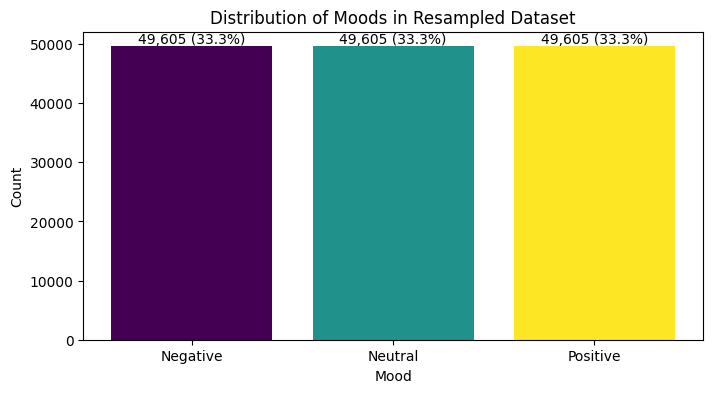

In [11]:
mood_mapping = {0: 'Neutral', 1: 'Positive', 2: 'Negative'}
r_df = pd.DataFrame({'Mood': y_train_resampled})
r_df['Mood'] = r_df['Mood'].map(mood_mapping)

mood_counts = r_df['Mood'].value_counts().sort_index()
colors = plt.get_cmap('viridis')(np.linspace(0, 1, len(mood_counts)))

plt.figure(figsize=(8, 4))
bars = plt.bar(mood_counts.index, mood_counts.values, color=colors)
plt.title('Distribution of Moods in Resampled Dataset')
plt.xlabel('Mood')
plt.ylabel('Count')

total_count = sum(mood_counts.values)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2., height, f'{int(height):,} ({height/total_count:.1%})',
             ha='center', va='bottom')

plt.show()


In [12]:
df['final_review'] = df['translated_text'].apply(lambda x:str(x).split())
top = Counter([item for sublist in df['final_review'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,cloud,18581
1,data,6547
2,lambda,5668
3,service,5348
4,engineer,5106
5,azure,4541
6,free,3385
7,learn,3358
8,support,3097
9,manager,2537


In [13]:
def remove_stopword(x):
    return [y for y in x if y not in stopwords.words('english')]

df['final_review'] = df['final_review'].apply(lambda x:remove_stopword(x))

top = Counter([item for sublist in df['final_review'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp = temp.iloc[1:,:]
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Purples')

,Common_words,count
1,data,6547
2,lambda,5668
3,service,5348
4,engineer,5106
5,azure,4541
6,free,3385
7,learn,3358
8,support,3097
9,manager,2537
10,security,2410


In [14]:
df['temp_review'] = df['translated_text'].apply(lambda x:str(x).split())
df['temp_review'] = df['temp_review'].apply(lambda x:remove_stopword(x))

def is_not_empty(lst):
    return bool(lst)

# Apply the function and filter the DataFrame
df_filtered = df[df['temp_review'].apply(is_not_empty)]

top = Counter([item for sublist in df['temp_review'] for item in sublist])
temp = pd.DataFrame(top.most_common(25))
temp = temp.iloc[1:,:]
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
1,data,6547
2,lambda,5668
3,service,5348
4,engineer,5106
5,azure,4541
6,free,3385
7,learn,3358
8,support,3097
9,manager,2537
10,security,2410


In [15]:
Positive_sent = df[df['Sentiment']=='Positive']
Negative_sent = df[df['Sentiment']=='Negative']
Neutral_sent = df[df['Sentiment']=='Neutral']

In [16]:
# MosT common positive words
top = Counter([item for sublist in Positive_sent['final_review'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(20))
temp_positive.columns = ['Common_words','count']
temp_positive.style.background_gradient(cmap='Greens')

,Common_words,count
0,cloud,4482
1,free,2971
2,support,2297
3,data,1619
4,help,1440
5,lambda,1428
6,join,1397
7,service,1370
8,learn,1313
9,great,1186


In [17]:
# MosT common negative words
top = Counter([item for sublist in Negative_sent['final_review'] for item in sublist])
temp_negative = pd.DataFrame(top.most_common(20))
temp_negative = temp_negative.iloc[1:,:]
temp_negative.columns = ['Common_words','count']
temp_negative.style.background_gradient(cmap='Reds')

,Common_words,count
1,price,559
2,azure,483
3,apple,306
4,service,283
5,data,271
6,problem,250
7,still,234
8,lambda,207
9,instance,200
10,time,181


In [18]:
# MosT common Neutral words
top = Counter([item for sublist in Neutral_sent['final_review'] for item in sublist])
temp_neutral = pd.DataFrame(top.most_common(20))
temp_neutral = temp_neutral.loc[1:,:]
temp_neutral.columns = ['Common_words','count']
temp_neutral.style.background_gradient(cmap='Reds')

,Common_words,count
1,data,4657
2,engineer,4420
3,lambda,4033
4,service,3695
5,azure,3130
6,manager,2068
7,learn,1963
8,security,1733
9,region,1629
10,developer,1490


In [19]:
raw_text = [word for word_list in df['temp_review'] for word in word_list]
df['review'] = df['temp_review'].apply(lambda x: ' '.join(set(x)))

def words_unique(sentiment,numwords,raw_words):
    allother = []
    for item in df[df.Sentiment != sentiment]['temp_review']:
        for word in item:
            allother .append(word)
    allother  = list(set(allother ))
    
    specificnonly = [x for x in raw_text if x not in allother]
    
    mycounter = Counter()
    
    for item in df[df.Sentiment == sentiment]['temp_review']:
        for word in item:
            mycounter[word] += 1
    keep = list(specificnonly)
    
    for word in list(mycounter):
        if word not in keep:
            del mycounter[word]
    
    Unique_words = pd.DataFrame(mycounter.most_common(numwords), columns = ['words','count'])
    
    return Unique_words

In [20]:
# The top 10 unique words in Positive Tweets
Unique_Positive= words_unique('Positive', 10, raw_text)
print("The top 10 unique words in Positive Tweets are:")
Unique_Positive.style.background_gradient(cmap='Greens')

The top 10 unique words in Positive Tweets are:


,words,count
0,kudos,131
1,bearer,88
2,almighty,71
3,stirring,71
4,divine,71
5,impressive,59
6,exclusive,57
7,fascinating,48
8,passionate,31
9,wonderful,25


In [21]:
# The top 10 unique words in Negative Tweets
Unique_Negative= words_unique('Negative', 10, raw_text)
print("The top 10 unique words in Negative Tweets are:")
Unique_Negative.style.background_gradient(cmap='Reds')

The top 10 unique words in Negative Tweets are:


,words,count
0,rollback,71
1,aggressive,43
2,skepticism,23
3,drown,20
4,blocked,16
5,clash,15
6,dependence,15
7,skeptic,15
8,fighter,13
9,wacky,12


In [22]:
# The top 10 unique words in Neutral Tweets
Unique_Neutral= words_unique('Neutral', 10, raw_text)
print("The top 10 unique words in Neutral Tweets are:")
Unique_Neutral.style.background_gradient(cmap='Oranges')

The top 10 unique words in Neutral Tweets are:


,words,count
0,technician,112
1,standardized,70
2,shim,68
3,proto,65
4,statistics,57
5,rank,54
6,crunching,52
7,shook,52
8,empire,45
9,campanile,41


# Build Model and Tuning - Balanced Data
- Model Building: Construct models using Logistic Regression, Random Forest, and XGBoost.
- Parameter Tuning: Adjust default parameters to optimize model performance and improve training results.
- Using CountVectorizer vs TfidfVectorizer

### Logistic Regression - Using CountVectorizer

In [156]:
# Step 1: Vectorize the text data using CountVectorizer
vectorizer_cv = CountVectorizer()
X_vect = vectorizer_cv.fit_transform(df.review)

# Step 2: Split the data into training and test sets
y = df.Mood
X_train_cv, X_test_cv, y_train_cv, y_test_cv = train_test_split(X_vect, df.Mood, test_size=0.2,  stratify=y, random_state=42)

# Step 3: Apply SMOTE to the training set only
smote_cv = SMOTE(random_state=42)
X_train_resampled_cv, y_train_resampled_cv = smote_cv.fit_resample(X_train_cv, y_train_cv)

In [157]:
# Count occurrences of each class
unique, counts = np.unique(y_train_resampled_cv, return_counts=True)
class_distribution = dict(zip(unique, counts))

print(class_distribution)

{0: 49605, 1: 49605, 2: 49605}


Training accuracy Score:  0.8818331485401337
Testing accuracy Score:  0.8818331485401337

Logistic Regression Results:
Accuracy: 0.8818
Precision: 0.8834
Recall: 0.8818
F1 Score: 0.8811
ROC AUC Score: 0.9708
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.88      0.89     49605
           1       0.90      0.82      0.86     49605
           2       0.86      0.95      0.90     49605

    accuracy                           0.88    148815
   macro avg       0.88      0.88      0.88    148815
weighted avg       0.88      0.88      0.88    148815



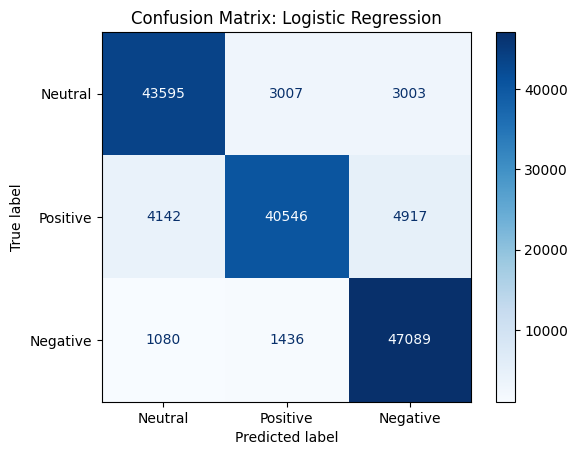

In [158]:
# Step 4: Define and train the Logistic Regression model pipeline
model_LR_countv = LogisticRegression(max_iter=10000, penalty='l2', random_state=42)

# Train the model on the resampled training data
model_LR_countv.fit(X_train_resampled_cv, y_train_resampled_cv)

# Step 5: Predict and evaluate the model
y_pred_train = model_LR_countv.predict(X_train_resampled_cv)
y_pred_test = model_LR_countv.predict(X_test_cv)

# Evaluate the model using y_test and y_pred_test
accuracy = accuracy_score(y_train_resampled_cv, y_pred_train)
precision = precision_score(y_train_resampled_cv, y_pred_train, average='weighted')
recall = recall_score(y_train_resampled_cv, y_pred_train, average='weighted')
f1 = f1_score(y_train_resampled_cv, y_pred_train, average='weighted')
y_train_prob = model_LR_countv.predict_proba(X_train_resampled_cv)
roc_auc = roc_auc_score(y_train_resampled_cv, y_train_prob, multi_class='ovr')

print("Training accuracy Score: ", model_LR_countv.score(X_train_resampled_cv, y_train_resampled_cv))
print("Testing accuracy Score: ", accuracy)
print(f"\nLogistic Regression Results:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

# Classification Report
print('Classification Report:\n', classification_report(y_train_resampled_cv, y_pred_train))

# Confusion Matrix
conf_matrix = metrics.confusion_matrix(y_train_resampled_cv, y_pred_train)
display_labels = ['Neutral', 'Positive', 'Negative']
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=display_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix: Logistic Regression")
plt.show()




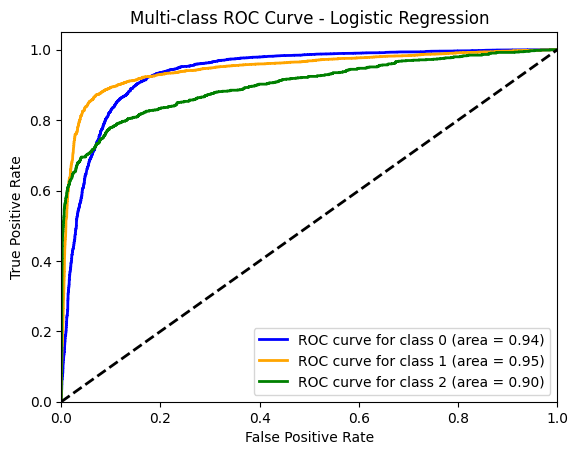

In [159]:
# Binarize the output labels
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

# Calculate the probability estimates
y_pred_prob = model_LR_countv.predict_proba(X_test_cv)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure()
colors = ['blue', 'orange', 'green']
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label='ROC curve for class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve - Logistic Regression')
plt.legend(loc="lower right")
plt.show()


### Logistic Regression - Using TfidfVectorizer

In [139]:
# Step 1: Vectorize the text data using TfidfVectorizer
vectorizer_tfidf = TfidfVectorizer()
X_vect = vectorizer_tfidf.fit_transform(df['review'])

# Step 2: Split the data into training and test sets
X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(X_vect, df.Mood, test_size=0.2,  stratify=y, random_state=42)

# Step 3: Apply SMOTE to the training set only
smote_tf = SMOTE(k_neighbors=5,random_state=42)
X_train_resampled_tf, y_train_resampled_tf = smote_tf.fit_resample(X_train_tf, y_train_tf)

In [140]:
print(X_train_tf.shape, y_train_tf.shape)
print(X_test_tf.shape, y_test_tf.shape)
print(y_train_tf.value_counts())

(74768, 8054) (74768,)
(18692, 8054) (18692,)
Mood
0    49605
1    20992
2     4171
Name: count, dtype: int64


Training accuracy Score:  0.8785203104525754
Testing accuracy Score:  0.9206598797164265

Logistic Regression Results:
Accuracy: 0.9207
Precision: 0.9207
Recall: 0.9207
F1 Score: 0.9206
ROC AUC Score: 0.9817
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.91      0.90     49605
           1       0.92      0.90      0.91     49605
           2       0.94      0.95      0.95     49605

    accuracy                           0.92    148815
   macro avg       0.92      0.92      0.92    148815
weighted avg       0.92      0.92      0.92    148815



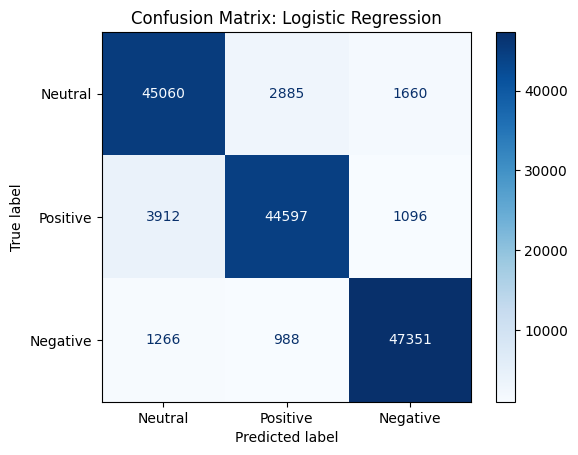

In [160]:
# Step 4: Define and train the Logistic Regression model pipeline
model_LR_tfidf = LogisticRegression(max_iter=10000, penalty='l2', random_state=42)

# Train the model on the resampled training data
model_LR_tfidf.fit(X_train_resampled_tf, y_train_resampled_tf)

# Step 5: Predict and evaluate the model
y_pred_train = model_LR_tfidf.predict(X_train_resampled_tf)
y_pred_test = model_LR_tfidf.predict(X_test_tf)

# Evaluate the model using y_test and y_pred_test
accuracy = accuracy_score(y_train_resampled_tf, y_pred_train)
precision = precision_score(y_train_resampled_tf, y_pred_train, average='weighted')
recall = recall_score(y_train_resampled_tf, y_pred_train, average='weighted')
f1 = f1_score(y_train_resampled_tf, y_pred_train, average='weighted')
y_train_prob = model_LR_tfidf.predict_proba(X_train_resampled_tf)
roc_auc = roc_auc_score(y_train_resampled_tf, y_train_prob, multi_class='ovr')

print("Training accuracy Score: ", model_LR_countv.score(X_train_resampled_tf, y_train_resampled_tf))
print("Testing accuracy Score: ", accuracy)
print(f"\nLogistic Regression Results:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

# Classification Report
print('Classification Report:\n', classification_report(y_train_resampled_tf, y_pred_train))

# Confusion Matrix
conf_matrix = metrics.confusion_matrix(y_train_resampled_tf, y_pred_train)
display_labels = ['Neutral', 'Positive', 'Negative']
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=display_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix: Logistic Regression")
plt.show()

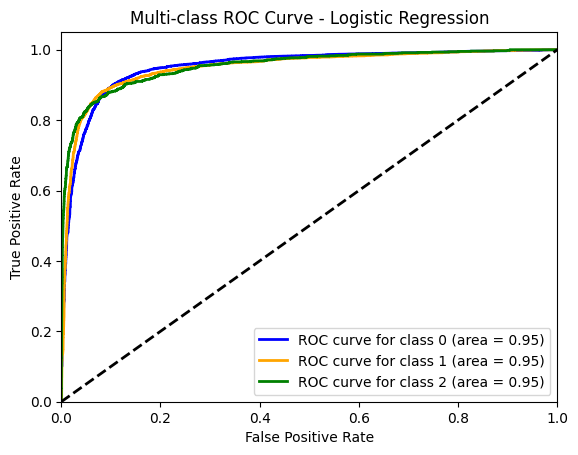

In [161]:
# Binarize the output labels
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

# Calculate the probability estimates
y_pred_prob = model_LR_tfidf.predict_proba(X_test_tf)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure()
colors = ['blue', 'orange', 'green']
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label='ROC curve for class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve - Logistic Regression')
plt.legend(loc="lower right")
plt.show()


### Random Forest Classifier - Using CountVectorizer

Training accuracy Score:  0.8818331485401337
Testing accuracy Score:  0.9463562140913214

Random Forest Classifier Results:
Accuracy: 0.9464
Precision: 0.9472
Recall: 0.9464
F1 Score: 0.9464
ROC AUC Score: 0.9935
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.95      0.96     49605
           1       0.95      0.92      0.93     49605
           2       0.92      0.97      0.94     49605

    accuracy                           0.95    148815
   macro avg       0.95      0.95      0.95    148815
weighted avg       0.95      0.95      0.95    148815



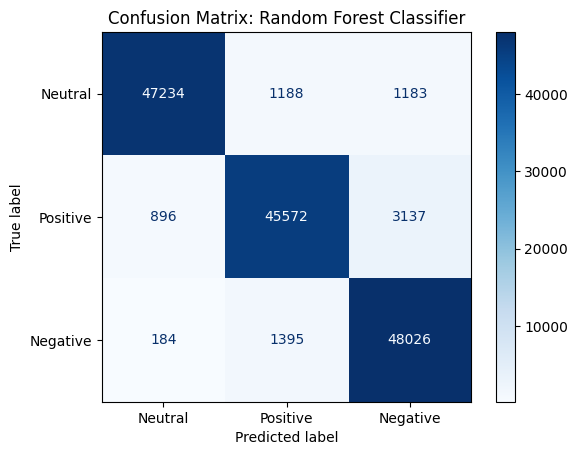

In [181]:
# Step 4: Define and train the Random Forest model pipeline
model_rf_countv = RandomForestClassifier(
    #n_estimators=100,         # Number of trees in the forest
    #max_depth=None,           # Maximum depth of the trees
    random_state=42,          # Seed for reproducibility
    n_jobs=-1                 # Use all available CPU cores
)

# Train the model on the resampled training data
model_rf_countv.fit(X_train_resampled_cv, y_train_resampled_cv)

# Step 5: Predict and evaluate the model
y_pred_train = model_rf_countv.predict(X_train_resampled_cv)
y_pred_test = model_rf_countv.predict(X_test_cv)

# Evaluate the model using y_test and y_pred_test
accuracy = accuracy_score(y_train_resampled_cv, y_pred_train)
precision = precision_score(y_train_resampled_cv, y_pred_train, average='weighted')
recall = recall_score(y_train_resampled_cv, y_pred_train, average='weighted')
f1 = f1_score(y_train_resampled_cv, y_pred_train, average='weighted')
y_train_prob = model_rf_countv.predict_proba(X_train_resampled_cv)
roc_auc = roc_auc_score(y_train_resampled_cv, y_train_prob, multi_class='ovr')

print("Training accuracy Score: ", model_LR_countv.score(X_train_resampled_cv, y_train_resampled_cv))
print("Testing accuracy Score: ", accuracy)
print(f"\nRandom Forest Classifier Results:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

# Classification Report
print('Classification Report:\n', classification_report(y_train_resampled_cv, y_pred_train))

# Confusion Matrix
conf_matrix = metrics.confusion_matrix(y_train_resampled_cv, y_pred_train)
display_labels = ['Neutral', 'Positive', 'Negative']
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=display_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix: Random Forest Classifier")
plt.show()


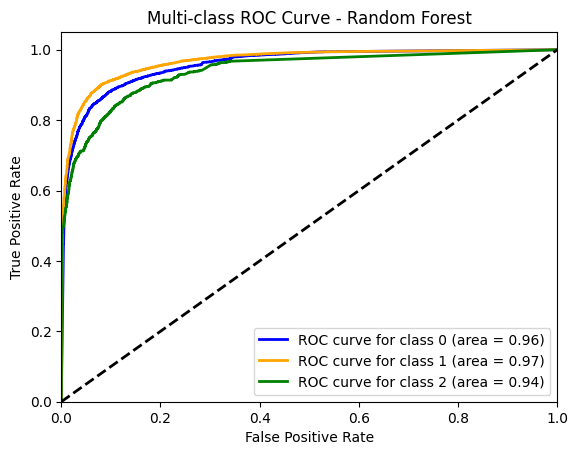

In [179]:
# Binarize the output labels
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

# Calculate the probability estimates
y_pred_prob = model_rf_countv.predict_proba(X_test_cv)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure()
colors = ['blue', 'orange', 'green']
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label='ROC curve for class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve - Random Forest')
plt.legend(loc="lower right")
plt.show()


### Random Forest Classifier - Using TfidfVectorizer

Training accuracy Score:  0.8785203104525754
Testing accuracy Score:  0.992682189295434

Logistic Regression Results:
Accuracy: 0.9927
Precision: 0.9927
Recall: 0.9927
F1 Score: 0.9927
ROC AUC Score: 0.9996
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99     49605
           1       0.99      0.99      0.99     49605
           2       1.00      1.00      1.00     49605

    accuracy                           0.99    148815
   macro avg       0.99      0.99      0.99    148815
weighted avg       0.99      0.99      0.99    148815



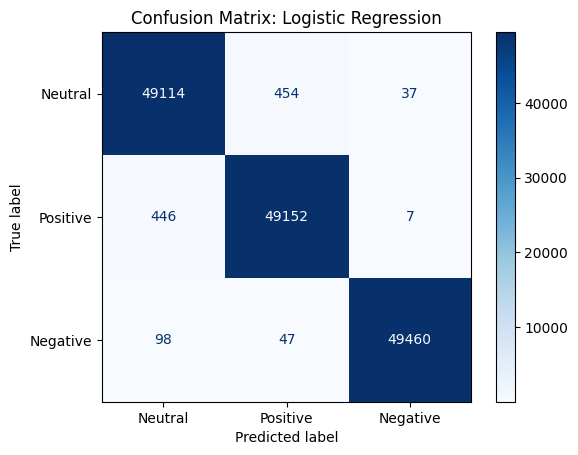

In [164]:
# Step 4: Define and train the Random Forest model pipeline
model_rf_tfidf = RandomForestClassifier(n_jobs=-1, random_state=42)

# Train the model on the resampled training data
model_rf_tfidf.fit(X_train_resampled_tf, y_train_resampled_tf)

# Step 5: Predict and evaluate the model
y_pred_train = model_rf_tfidf.predict(X_train_resampled_tf)
y_pred_test = model_rf_tfidf.predict(X_test_tf)

# Evaluate the model 
accuracy = accuracy_score(y_train_resampled_tf, y_pred_train)
precision = precision_score(y_train_resampled_tf, y_pred_train, average='weighted')
recall = recall_score(y_train_resampled_tf, y_pred_train, average='weighted')
f1 = f1_score(y_train_resampled_tf, y_pred_train, average='weighted')
y_train_prob = model_rf_tfidf.predict_proba(X_train_resampled_tf)
roc_auc = roc_auc_score(y_train_resampled_tf, y_train_prob, multi_class='ovr')

print("Training accuracy Score: ", model_LR_countv.score(X_train_resampled_tf, y_train_resampled_tf))
print("Testing accuracy Score: ", accuracy)
print(f"\nLogistic Regression Results:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

# Classification Report
print('Classification Report:\n', classification_report(y_train_resampled_tf, y_pred_train))

# Confusion Matrix
conf_matrix = metrics.confusion_matrix(y_train_resampled_tf, y_pred_train)
display_labels = ['Neutral', 'Positive', 'Negative']
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=display_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix: Random Forest Classifier")
plt.show()


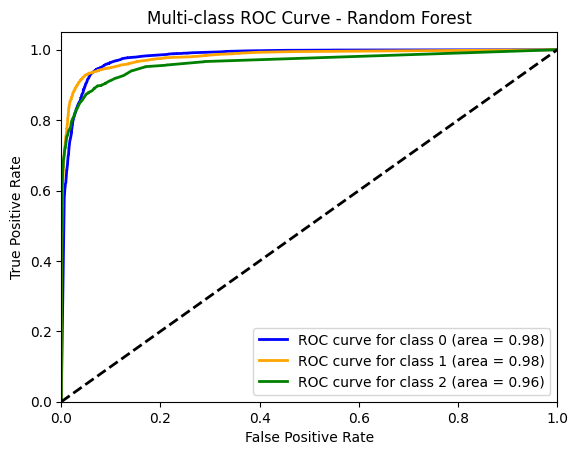

In [165]:
# Binarize the output labels
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

# Calculate the probability estimates
y_pred_prob = model_rf_tfidf.predict_proba(X_test_tf)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure()
colors = ['blue', 'orange', 'green']
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label='ROC curve for class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve - Random Forest')
plt.legend(loc="lower right")
plt.show()


### XGBoost - Using CountVectorizer

Training accuracy Score:  0.8818331485401337
Testing accuracy Score:  0.9439639821254577

XGBoost Results:
Accuracy: 0.9440
Precision: 0.9457
Recall: 0.9440
F1 Score: 0.9441
ROC AUC Score: 0.9895
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.97      0.93     49605
           1       0.96      0.91      0.93     49605
           2       0.98      0.96      0.97     49605

    accuracy                           0.94    148815
   macro avg       0.95      0.94      0.94    148815
weighted avg       0.95      0.94      0.94    148815



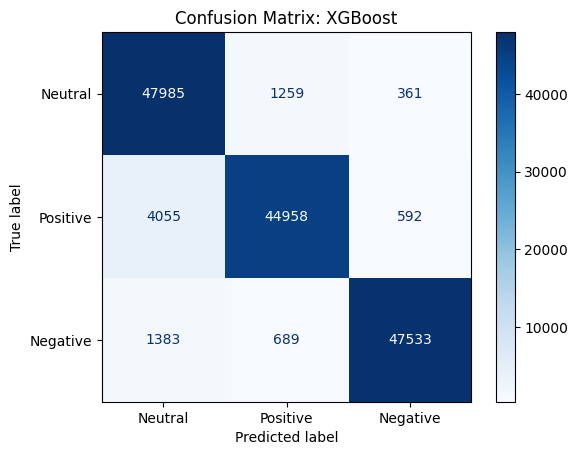

In [185]:
# Step 4: Define and train the XGBoost model
model_xgb_countv = XGBClassifier(
    n_estimators=400,          # Number of boosting rounds
    num_class=3,
    random_state=42,           
    use_label_encoder=False,   # Disable the label encoder warning
    eval_metric='mlogloss',    # Evaluation metric for multi-class classification
    objective='multi:softmax'
)
# Train the model on the resampled training data
model_xgb_countv.fit(X_train_resampled_cv, y_train_resampled_cv)

# Step 5: Predict and evaluate the model
y_pred_train = model_xgb_countv.predict(X_train_resampled_cv)
y_pred_test = model_xgb_countv.predict(X_test_cv)

# Evaluate the model using y_test and y_pred_test
accuracy = accuracy_score(y_train_resampled_cv, y_pred_train)
precision = precision_score(y_train_resampled_cv, y_pred_train, average='weighted')
recall = recall_score(y_train_resampled_cv, y_pred_train, average='weighted')
f1 = f1_score(y_train_resampled_cv, y_pred_train, average='weighted')
y_train_prob = model_xgb_countv.predict_proba(X_train_resampled_cv)
roc_auc = roc_auc_score(y_train_resampled_cv, y_train_prob, multi_class='ovr')

print("Training accuracy Score: ", model_LR_countv.score(X_train_resampled_cv, y_train_resampled_cv))
print("Testing accuracy Score: ", accuracy)
print(f"\nXGBoost Results:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

# Classification Report
print('Classification Report:\n', classification_report(y_train_resampled_cv, y_pred_train))

# Confusion Matrix
conf_matrix = metrics.confusion_matrix(y_train_resampled_cv, y_pred_train)
display_labels = ['Neutral', 'Positive', 'Negative']
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=display_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix: XGBoost")
plt.show()

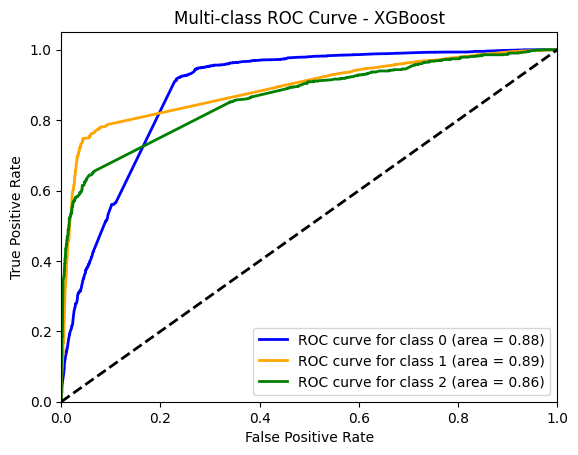

In [167]:
# Binarize the output labels
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

# Calculate the probability estimates
y_pred_prob = model_xgb_countv.predict_proba(X_test_cv)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure()
colors = ['blue', 'orange', 'green']
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label='ROC curve for class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve - XGBoost')
plt.legend(loc="lower right")
plt.show()


### XGBoost - Using TfidfVectorizer

Training accuracy Score:  0.8785203104525754
Testing accuracy Score:  0.9515237039276955

Logistic Regression Results:
Accuracy: 0.9515
Precision: 0.9529
Recall: 0.9515
F1 Score: 0.9516
ROC AUC Score: 0.9929
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.97      0.94     49605
           1       0.97      0.92      0.94     49605
           2       0.98      0.97      0.97     49605

    accuracy                           0.95    148815
   macro avg       0.95      0.95      0.95    148815
weighted avg       0.95      0.95      0.95    148815



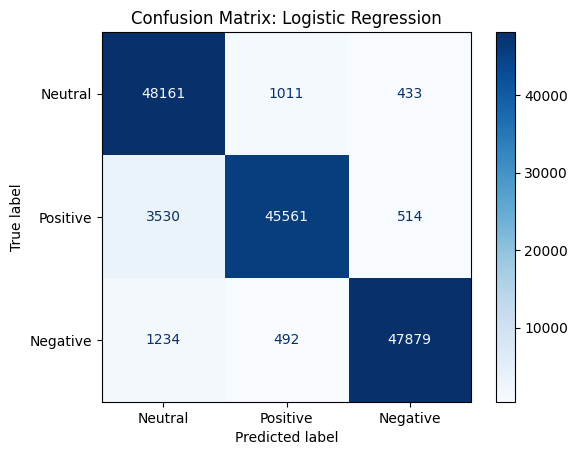

In [168]:
# Step 4: Define and train the XGBoost model
model_xgb_tfidf = XGBClassifier(
    n_estimators=400,          # Number of boosting rounds
    num_class=3,
    random_state=42,           
    use_label_encoder=False,   # Disable the label encoder warning
    eval_metric='mlogloss',    # Evaluation metric for multi-class classification
    objective='multi:softmax'
)

# Train the model on the resampled training data
model_xgb_tfidf.fit(X_train_resampled_tf, y_train_resampled_tf)

# Step 5: Predict and evaluate the model
y_pred_train = model_xgb_tfidf.predict(X_train_resampled_tf)
y_pred_test = model_xgb_tfidf.predict(X_test_tf)

# Evaluate the model using y_test and y_pred_test
accuracy = accuracy_score(y_train_resampled_tf, y_pred_train)
precision = precision_score(y_train_resampled_tf, y_pred_train, average='weighted')
recall = recall_score(y_train_resampled_tf, y_pred_train, average='weighted')
f1 = f1_score(y_train_resampled_tf, y_pred_train, average='weighted')
y_train_prob = model_xgb_tfidf.predict_proba(X_train_resampled_tf)
roc_auc = roc_auc_score(y_train_resampled_tf, y_train_prob, multi_class='ovr')

print("Training accuracy Score: ", model_LR_countv.score(X_train_resampled_tf, y_train_resampled_tf))
print("Testing accuracy Score: ", accuracy)
print(f"\nLogistic Regression Results:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

# Classification Report
print('Classification Report:\n', classification_report(y_train_resampled_tf, y_pred_train))

# Confusion Matrix
conf_matrix = metrics.confusion_matrix(y_train_resampled_tf, y_pred_train)
display_labels = ['Neutral', 'Positive', 'Negative']
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=display_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix: XGBoost")
plt.show()


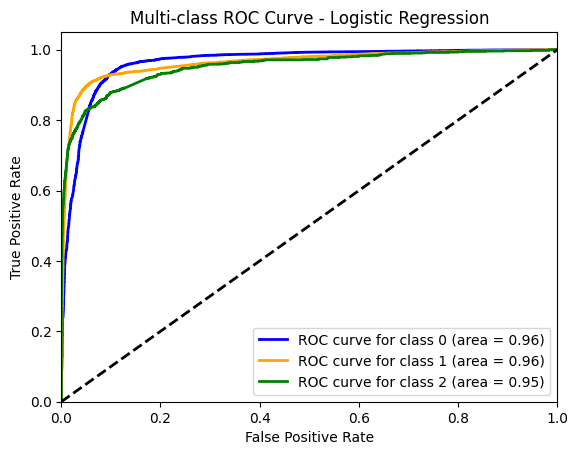

In [169]:
# Binarize the output labels
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

# Calculate the probability estimates
y_pred_prob = model_xgb_tfidf.predict_proba(X_test_tf)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure()
colors = ['blue', 'orange', 'green']
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label='ROC curve for class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve - Logistic Regression')
plt.legend(loc="lower right")
plt.show()


# Model - Summary
- Random Forest remains the top performer with the highest 93.40% accuracy, 93.31% precision, 93.40% recall, 93.32% f1-score and 97.52% ROC AUC score.
- XGBoost shows strong performance overall but has similar challenges with classifying negative sentiment as observed in other models.
- Logistic Regression provides a good baseline with competitive performance but is outperformed by Random Forest and XGBoost.


# Stacking Ensemble
- Given these results, Random Forest seems to be the most robust model for your dataset, especially in terms of accuracy and ROC AUC. However, XGBoost could be beneficial for specific scenarios or in combination with other models to improve performance on negative sentiment classification.

Stacking Ensemble Model Performance:
Accuracy: 0.9791
Precision: 0.9791
Recall: 0.9791
F1 Score: 0.9791
ROC AUC Score: 0.9708
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     49605
           1       0.98      0.97      0.97     49605
           2       0.98      0.99      0.99     49605

    accuracy                           0.98    148815
   macro avg       0.98      0.98      0.98    148815
weighted avg       0.98      0.98      0.98    148815



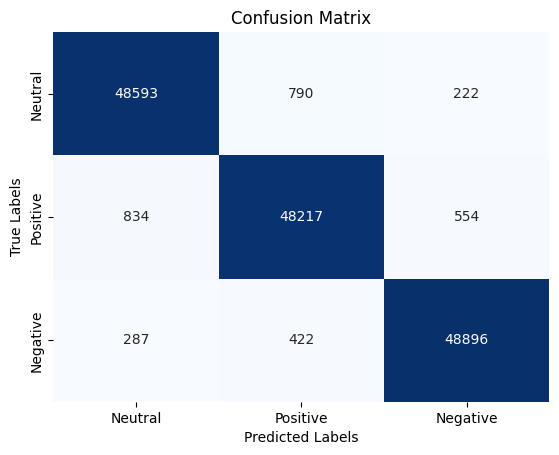

In [191]:
# Step 4: Train base models
xgb_model = model_xgb_countv
rf_model = model_rf_countv
lr_model = model_LR_countv

# Step 5: Generate predictions for the meta-model
xgb_train_preds = xgb_model.predict_proba(X_train_resampled_cv)
rf_train_preds = rf_model.predict_proba(X_train_resampled_cv)
lr_train_preds = lr_model.predict_proba(X_train_resampled_cv)

# Step 6: Combine predictions into a new feature matrix for the meta-model
meta_features_train = np.hstack((xgb_train_preds, rf_train_preds, lr_train_preds))

# Step 7: Train meta-model
meta_model = LogisticRegression()
meta_model.fit(meta_features_train, y_train_resampled_cv)

# Step 8: Make predictions on the test set
xgb_test_preds = xgb_model.predict_proba(X_test_tf)
rf_test_preds = rf_model.predict_proba(X_test_tf)
lr_test_preds = lr_model.predict_proba(X_test_tf)

# Step 9: Combine test set predictions
meta_features_test = np.hstack((xgb_test_preds, rf_test_preds, lr_test_preds))

# Step 10: Final predictions using the meta-model
final_predictions = meta_model.predict(meta_features_train)

# Step 11: Evaluate the model
print("Stacking Ensemble Model Performance:")
#print(f"Accuracy: {accuracy_score(y_test, final_predictions):.4f}")
accuracy = accuracy_score(y_train_resampled_cv, final_predictions)
precision = precision_score(y_train_resampled_cv, final_predictions, average='weighted')
recall = recall_score(y_train_resampled_cv, final_predictions, average='weighted')
f1 = f1_score(y_train_resampled_cv, final_predictions, average='weighted')
roc_auc = roc_auc_score(y_train_resampled_cv, model_LR_countv.predict_proba(X_train_resampled_cv), multi_class='ovr')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print("Classification Report:")
print(classification_report(y_train_resampled_cv, final_predictions))

# Compute and print the confusion matrix
conf_matrix = confusion_matrix(y_train_resampled_cv, final_predictions)

# Plot the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=False,
            xticklabels=['Neutral', 'Positive', 'Negative'],
            yticklabels=['Neutral', 'Positive', 'Negative'])

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


#  Evaluation of Stacking Ensemble and Random Forest Model Performance on Test Data

The script evaluates the performance of a stacking ensemble model on a test set, analyzes a subset of the test samples for detailed insights.

In [182]:
# Define the pipeline with the stacking model
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer()),  # Vectorizer included in the pipeline
    ('stacking', meta_model)  # Stacking model included in the pipeline
])

# Fit the pipeline
pipeline.fit(X_train, y_train)

# Evaluate on the test set
y_pred = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)

# Print overall accuracy
print("Stacking Ensemble Model Performance:")
overall_acc = accuracy_score(y_test, y_pred)
print(f"Overall Accuracy: {overall_acc:.4f}")

# Ensure X_test is a DataFrame
if isinstance(X_test, pd.Series):
    X_test = X_test.reset_index(drop=True)

# Define mapping from Mood integer to class names
mood_mapping = {0: 'Neutral', 1: 'Positive', 2: 'Negative'}

# Ensure we do not exceed the number of available samples
num_test = 2000
num_samples = min(num_test, len(X_test))  
selected_indices = list(range(num_samples))

# Prepare lists to store results
results = []
total_individual_accuracy = 0
mismatch_count = 0  # Initialize count of mismatches

# Loop through the selected samples
for idx in selected_indices:
    text_sample = X_test.iloc[idx] if isinstance(X_test, pd.DataFrame) else X_test[idx]
    class_names = ['Neutral', 'Positive', 'Negative']

    # Get the predicted probabilities
    probs = y_pred_proba[idx]

    # Get the predicted class and true class
    predicted_class_idx = pipeline.predict([text_sample])[0]
    predicted_class = class_names[predicted_class_idx]
    true_class_idx = y_test.iloc[idx] if isinstance(y_test, pd.Series) else y_test[idx]
    true_class = class_names[true_class_idx]

    # Check if there's a mismatch
    if predicted_class != true_class:
        mismatch_count += 1

    # Calculate individual accuracy as the average of the predicted probabilities
    individual_accuracy = ((probs[0] + probs[1] + probs[2]) / 3)
    total_individual_accuracy += individual_accuracy  

    # Append results to the list
    results.append({
        'Review ID': idx,
        'Review Text': textwrap.fill(text_sample, 400),
        'P(Neutral)': f'{probs[0]:.4f}',
        'P(Positive)': f'{probs[1]:.4f}',
        'P(Negative)': f'{probs[2]:.4f}',
        'True Class': true_class,
        'Predicted Class': predicted_class,
    })

# Calculate overall accuracy as the average of individual accuracies
overall_acc = total_individual_accuracy / num_samples

# Create a DataFrame from the results
results_df = pd.DataFrame(results)

# Generate timestamp for the filename
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Save the DataFrame to a CSV file with timestamp
csv_filename = f"Stacking_Ensemble_Model_Performance_{mismatch_count}_{num_samples}.csv"
results_df.to_csv(csv_filename, index=False)

# Display the results as a table
print(results_df)

# Print the count of mismatches
print(f"Number of mismatches: {mismatch_count}")

Stacking Ensemble Model Performance:
Overall Accuracy: 0.8898
      Review ID                                                   Review Text P(Neutral) P(Positive) P(Negative) True Class Predicted Class
0             0  fully backup process minute with fluid searchable free trial     0.2353      0.7211      0.0436   Positive        Positive
1             1                                                mobile android     0.8538      0.1151      0.0311    Neutral         Neutral
2             2             struggling build application master data pipeline     0.4276      0.0689      0.5035   Negative        Negative
3             3                                        support protocol learn     0.1581      0.8270      0.0148   Positive        Positive
4             4                     launch migration service preview customer     0.9066      0.0752      0.0182    Neutral         Neutral
...         ...                                                           ...        ...         .

In [109]:
sample_test = pd.read_csv(r"Stacking_Ensemble_Model_Performance_111_1000.csv")

# Print the updated DataFrame ensuring no column wrapping
pd.set_option('display.max_colwidth', None)  # Ensure full column width is visible
pd.set_option('display.max_columns', None)   # Show all columns
pd.set_option('display.width', 1000)         # Set width to handle wider DataFrames

print(sample_test.head())

   Review ID                                                   Review Text  P(Neutral)  P(Positive)  P(Negative) True Class Predicted Class
0          0  fully backup process minute with fluid searchable free trial      0.7277       0.2627       0.0096   Positive         Neutral
1          1                                                mobile android      0.8415       0.1474       0.0111    Neutral         Neutral
2          2             struggling build application master data pipeline      0.2732       0.0873       0.6396   Negative        Negative
3          3                                        support protocol learn      0.0703       0.9243       0.0055   Positive        Positive
4          4                     launch migration service preview customer      0.9387       0.0535       0.0079    Neutral         Neutral


In [110]:
# Filter the DataFrame for rows where True Class is not equal to Predicted Class
mismatched_records = sample_test[sample_test['True Class'] != sample_test['Predicted Class']]

# Display only specific columns
columns_to_display = ['Review Text', 'P(Neutral)', 'P(Positive)', 'P(Negative)', 'True Class', 'Predicted Class']
print(mismatched_records[columns_to_display])

# Save mismatched records to a new CSV file
mismatched_records.to_csv('Mismatched_Records_EM.csv', index=False)

                                                                                Review Text  P(Neutral)  P(Positive)  P(Negative) True Class Predicted Class
0                              fully backup process minute with fluid searchable free trial      0.7277       0.2627       0.0096   Positive         Neutral
8    engineer experience shipping code live production environment willingness learn docker      0.8919       0.1044       0.0038   Positive         Neutral
9                                given momentum underestimate insane business forget retail      0.6357       0.2659       0.0984   Negative         Neutral
11                   what priced like glacier cheap store take somewhere expensive retrieve      0.3240       0.5681       0.1079    Neutral        Positive
23                                      fair point carry also life much easier learn docker      0.8438       0.1371       0.0192   Positive         Neutral
..                                                        

In [111]:
print(f"Shape: {sample_test.shape}")
print()

# Filter the DataFrame for rows where True Class is not equal to Predicted Class
mismatched_records = sample_test[sample_test['True Class'] != sample_test['Predicted Class']]
print(f"Stacking Ensemble Prediction Error: {len(mismatched_records)}")


# Display only specific columns
columns_to_display = ['Review Text', 'P(Neutral)', 'P(Positive)', 'P(Negative)', 'True Class', 'Predicted Class']
print(mismatched_records[columns_to_display].head(10))


Shape: (1000, 7)

Stacking Ensemble Prediction Error: 111
                                                                               Review Text  P(Neutral)  P(Positive)  P(Negative) True Class Predicted Class
0                             fully backup process minute with fluid searchable free trial      0.7277       0.2627       0.0096   Positive         Neutral
8   engineer experience shipping code live production environment willingness learn docker      0.8919       0.1044       0.0038   Positive         Neutral
9                               given momentum underestimate insane business forget retail      0.6357       0.2659       0.0984   Negative         Neutral
11                  what priced like glacier cheap store take somewhere expensive retrieve      0.3240       0.5681       0.1079    Neutral        Positive
23                                     fair point carry also life much easier learn docker      0.8438       0.1371       0.0192   Positive         Neutral
29    

In [104]:
sample_test_overall = pd.read_csv(r"Sample_Test_Stacking_Ensemble.csv")
sample_test_overall.head()

,Total Test Samples,True vs Predicted Mismatches
0,1000,111
1,2000,223
2,3000,304
3,4000,406
4,5000,504


The script evaluates the performance of a random forest model on a test set, analyzes a subset of the test samples for detailed insights.

In [183]:
# Define the pipeline with the stacking model
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer()),  # Vectorizer included in the pipeline
    ('stacking', model_rf_tfidf)  # Stacking model included in the pipeline
])

# Fit the pipeline
pipeline.fit(X_train, y_train)

# Evaluate on the test set
y_pred = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)

# Print overall accuracy
print("Random Forest Model Performance:")
overall_acc = accuracy_score(y_test, y_pred)
print(f"Overall Accuracy: {overall_acc:.4f}")

# Ensure X_test is a DataFrame
if isinstance(X_test, pd.Series):
    X_test = X_test.reset_index(drop=True)

# Define mapping from Mood integer to class names
mood_mapping = {0: 'Neutral', 1: 'Positive', 2: 'Negative'}

# Ensure we do not exceed the number of available samples
num_test = 2000
num_samples = min(num_test, len(X_test))  
selected_indices = list(range(num_samples))

# Prepare lists to store results
results = []
total_individual_accuracy = 0
mismatch_count = 0  # Initialize count of mismatches

# Loop through the selected samples
for idx in selected_indices:
    text_sample = X_test.iloc[idx] if isinstance(X_test, pd.DataFrame) else X_test[idx]
    class_names = ['Neutral', 'Positive', 'Negative']

    # Get the predicted probabilities
    probs = y_pred_proba[idx]

    # Get the predicted class and true class
    predicted_class_idx = pipeline.predict([text_sample])[0]
    predicted_class = class_names[predicted_class_idx]
    true_class_idx = y_test.iloc[idx] if isinstance(y_test, pd.Series) else y_test[idx]
    true_class = class_names[true_class_idx]

    # Check if there's a mismatch
    if predicted_class != true_class:
        mismatch_count += 1

    # Calculate individual accuracy as the average of the predicted probabilities
    individual_accuracy = ((probs[0] + probs[1] + probs[2]) / 3)
    total_individual_accuracy += individual_accuracy  

    # Append results to the list
    results.append({
        'Review ID': idx,
        'Review Text': textwrap.fill(text_sample, 400),
        'P(Neutral)': f'{probs[0]:.4f}',
        'P(Positive)': f'{probs[1]:.4f}',
        'P(Negative)': f'{probs[2]:.4f}',
        'True Class': true_class,
        'Predicted Class': predicted_class,
    })

# Calculate overall accuracy as the average of individual accuracies
overall_acc = total_individual_accuracy / num_samples

# Create a DataFrame from the results
results_df = pd.DataFrame(results)

# Generate timestamp for the filename
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Save the DataFrame to a CSV file with timestamp
csv_filename = f"Random_Forest_Model_Performance_{mismatch_count}_{num_samples}.csv"
results_df.to_csv(csv_filename, index=False)

# Display the results as a table
print(results_df)

# Print the count of mismatches
print(f"Number of mismatches: {mismatch_count}")


Random Forest Model Performance:
Overall Accuracy: 0.9428
      Review ID                                                   Review Text P(Neutral) P(Positive) P(Negative) True Class Predicted Class
0             0  fully backup process minute with fluid searchable free trial     0.0800      0.9100      0.0100   Positive        Positive
1             1                                                mobile android     1.0000      0.0000      0.0000    Neutral         Neutral
2             2             struggling build application master data pipeline     0.0000      0.0000      1.0000   Negative        Negative
3             3                                        support protocol learn     0.0000      1.0000      0.0000   Positive        Positive
4             4                     launch migration service preview customer     0.9013      0.0987      0.0000    Neutral         Neutral
...         ...                                                           ...        ...         ...  

In [106]:
sample_test_rf = pd.read_csv(r"Random_Forest_Model_Performance_57_1000.csv")

# Print the updated DataFrame ensuring no column wrapping
pd.set_option('display.max_colwidth', None)  # Ensure full column width is visible
pd.set_option('display.max_columns', None)   # Show all columns
pd.set_option('display.width', 1000)         # Set width to handle wider DataFrames

print(sample_test_rf.head())

   Review ID                                                   Review Text  P(Neutral)  P(Positive)  P(Negative) True Class Predicted Class
0          0  fully backup process minute with fluid searchable free trial      0.0800       0.9100         0.01   Positive        Positive
1          1                                                mobile android      1.0000       0.0000         0.00    Neutral         Neutral
2          2             struggling build application master data pipeline      0.0000       0.0000         1.00   Negative        Negative
3          3                                        support protocol learn      0.0000       1.0000         0.00   Positive        Positive
4          4                     launch migration service preview customer      0.9013       0.0987         0.00    Neutral         Neutral


In [107]:
# Filter the DataFrame for rows where True Class is not equal to Predicted Class
mismatched_records = sample_test_rf[sample_test_rf['True Class'] != sample_test_rf['Predicted Class']]

# Display only specific columns
columns_to_display = ['Review Text', 'P(Neutral)', 'P(Positive)', 'P(Negative)', 'True Class', 'Predicted Class']

# Save mismatched records to a new CSV file
mismatched_records.to_csv('Mismatched_Records_EM.csv', index=False)

In [108]:
print(f"Shape: {sample_test_rf.shape}")
print()

# Filter the DataFrame for rows where True Class is not equal to Predicted Class
mismatched_records = sample_test_rf[sample_test_rf['True Class'] != sample_test_rf['Predicted Class']]

print(f"Random Forest Prediction Error: {len(mismatched_records)}")


# Display only specific columns
columns_to_display = ['Review Text', 'P(Neutral)', 'P(Positive)', 'P(Negative)', 'True Class', 'Predicted Class']
print(mismatched_records[columns_to_display].head(10))


Shape: (1000, 7)

Random Forest Prediction Error: 57
                                                                                Review Text  P(Neutral)  P(Positive)  P(Negative) True Class Predicted Class
8    engineer experience shipping code live production environment willingness learn docker      0.9200       0.0700         0.01   Positive         Neutral
23                                      fair point carry also life much easier learn docker      0.8386       0.1414         0.02   Positive         Neutral
29                        ever axed popular service that always biggest fear cloud platform      0.3400       0.3900         0.27    Neutral        Positive
37                                              found marina democratic union freedom union      0.4400       0.4700         0.09    Neutral        Positive
44                                               innovative cloud solution data integration      0.4414       0.5586         0.00    Neutral        Positive
88   

In [105]:
sample_test_overall = pd.read_csv(r"Sample_Test_Random_Forest.csv")
sample_test_overall.head()

,Total Test Samples,True vs Predicted Mismatches
0,1000,57
1,2000,110
2,3000,176
3,4000,227
4,5000,278


In [47]:
pip install lime

In [102]:
from lime.lime_text import LimeTextExplainer
from IPython.core.display import display, HTML

# Create a LimeTextExplainer
explainer = LimeTextExplainer(class_names=['Neutral', 'Positive', 'Negative'])

# Define a function to predict probabilities
def predict_proba(texts):
    return pipeline.predict_proba(texts)

# Explain a specific instance
idx = 9  # Index of the instance to explain
text_instance = X_test.iloc[idx]
explanation = explainer.explain_instance(text_instance, predict_proba)

# Convert explanation to HTML
html_explanation = explanation.as_html()

# Display the explanation with custom CSS
display(HTML(html_explanation))


C:\Users\admin\AppData\Local\Temp\ipykernel_29268\481610205.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


# Cross-validation

Cross-validation is a technique used to evaluate the performance of a model by splitting the data into multiple folds.
This process helps in evaluating the performance of the model while handling class imbalance and ensuring reproducibility through the use of random states.

Model training and evaluation, where in each fold, the model is trained on the training set and evaluated on the test set. This process is repeated for all folds, and the performance metrics are averaged to get an overall assessment.

Random Forest Cross-validation

In [49]:
# Define the pipeline with Random Forest
rf_model = RandomForestClassifier(random_state=42)
SMOTE_pipeline_rf = make_pipeline(smote, rf_model)

def model_cv(splits, X, Y, pipeline, average_method):
    kfold = StratifiedKFold(n_splits=splits, shuffle=True, random_state=777)
    accuracy, precision, recall, f1 = [], [], [], []
    
    for train_index, test_index in kfold.split(X, Y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        
        # Fit the model on the training set
        model_fit = pipeline.fit(X_train, y_train)
        
        # Predict on the test set
        y_pred = model_fit.predict(X_test)
        
        # Calculate scores
        accuracy.append(model_fit.score(X_test, y_test) * 100)
        precision.append(precision_score(y_test, y_pred, average=average_method) * 100)
        recall.append(recall_score(y_test, y_pred, average=average_method) * 100)
        f1.append(f1_score(y_test, y_pred, average=average_method) * 100)
        
        # Print individual fold scores for debugging purposes
        print('              negative    neutral     positive')
        print('precision:', precision_score(y_test, y_pred, average=None))
        print('recall:   ', recall_score(y_test, y_pred, average=None))
        print('f1 score: ', f1_score(y_test, y_pred, average=None))
        print('-'*50)
    
    # Print overall scores
    print("accuracy: %.2f%%" % np.mean(accuracy))
    print("precision: %.2f%%" % np.mean(precision))
    print("recall: %.2f%%" % np.mean(recall))
    print("f1 score: %.2f%%" % np.mean(f1))

# Perform cross-validation
model_cv(5, X_train_resampled, y_train_resampled, SMOTE_pipeline_rf, 'macro')


              negative    neutral     positive
precision: [0.95008913 0.97021976 0.98901984]
recall:    [0.96703961 0.95232335 0.98961798]
f1 score:  [0.95848944 0.96118826 0.98931882]
--------------------------------------------------
              negative    neutral     positive
precision: [0.9489998  0.97232226 0.98733159]
recall:    [0.96593085 0.95252495 0.98981957]
f1 score:  [0.95739048 0.96232179 0.98857402]
--------------------------------------------------
              negative    neutral     positive
precision: [0.95191927 0.97373841 0.98914027]
recall:    [0.96986191 0.95302893 0.99153311]
f1 score:  [0.96080683 0.96327238 0.99033525]
--------------------------------------------------
              negative    neutral     positive
precision: [0.95143422 0.97509263 0.98842709]
recall:    [0.96955952 0.95494406 0.99002117]
f1 score:  [0.96041136 0.96491317 0.98922349]
--------------------------------------------------
              negative    neutral     positive
precision

Logistic Regression Cross-validation

In [50]:
# Define the pipeline with Logistic Regression
log_reg_model = LogisticRegression(random_state=42, max_iter=10000)
SMOTE_pipeline_log_reg = make_pipeline(smote, log_reg_model)

def model_cv(splits, X, Y, pipeline, average_method):
    kfold = StratifiedKFold(n_splits=splits, shuffle=True, random_state=777)
    accuracy, precision, recall, f1 = [], [], [], []
    
    for train_index, test_index in kfold.split(X, Y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        
        # Fit the model on the training set
        model_fit = pipeline.fit(X_train, y_train)
        
        # Predict on the test set
        y_pred = model_fit.predict(X_test)
        
        # Calculate scores
        accuracy.append(model_fit.score(X_test, y_test) * 100)
        precision.append(precision_score(y_test, y_pred, average=average_method) * 100)
        recall.append(recall_score(y_test, y_pred, average=average_method) * 100)
        f1.append(f1_score(y_test, y_pred, average=average_method) * 100)
        
        # Print individual fold scores for debugging purposes
        print('              negative    neutral     positive')
        print('precision:', precision_score(y_test, y_pred, average=None))
        print('recall:   ', recall_score(y_test, y_pred, average=None))
        print('f1 score: ', f1_score(y_test, y_pred, average=None))
        print('-'*50)
    
    # Print overall scores
    print("accuracy: %.2f%%" % np.mean(accuracy))
    print("precision: %.2f%%" % np.mean(precision))
    print("recall: %.2f%%" % np.mean(recall))
    print("f1 score: %.2f%%" % np.mean(f1))

# Perform cross-validation
model_cv(5, X_train_resampled, y_train_resampled, SMOTE_pipeline_log_reg, 'macro')

              negative    neutral     positive
precision: [0.88710482 0.90974804 0.93981297]
recall:    [0.89658301 0.88801532 0.95222256]
f1 score:  [0.89181873 0.89875032 0.94597707]
--------------------------------------------------
              negative    neutral     positive
precision: [0.880566   0.91384519 0.93746272]
recall:    [0.89698619 0.88418506 0.95040822]
f1 score:  [0.88870025 0.89877049 0.94389109]
--------------------------------------------------
              negative    neutral     positive
precision: [0.88120182 0.91398747 0.93879781]
recall:    [0.89869973 0.88257232 0.95242415]
f1 score:  [0.88986476 0.89800523 0.94556189]
--------------------------------------------------
              negative    neutral     positive
precision: [0.883979   0.91504222 0.94006153]
recall:    [0.89930451 0.88478984 0.95484326]
f1 score:  [0.8915759  0.89966178 0.94739474]
--------------------------------------------------
              negative    neutral     positive
precision

XGBoost cross validation

In [51]:
# Define the pipeline with XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
SMOTE_pipeline_xgb = make_pipeline(smote, xgb_model)

def model_cv(splits, X, Y, pipeline, average_method):
    kfold = StratifiedKFold(n_splits=splits, shuffle=True, random_state=777)
    accuracy, precision, recall, f1 = [], [], [], []
    
    for train_index, test_index in kfold.split(X, Y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        
        # Fit the model on the training set
        model_fit = pipeline.fit(X_train, y_train)
        
        # Predict on the test set
        y_pred = model_fit.predict(X_test)
        
        # Calculate scores
        accuracy.append(model_fit.score(X_test, y_test) * 100)
        precision.append(precision_score(y_test, y_pred, average=average_method) * 100)
        recall.append(recall_score(y_test, y_pred, average=average_method) * 100)
        f1.append(f1_score(y_test, y_pred, average=average_method) * 100)
        
        # Print individual fold scores for debugging purposes
        print('              negative    neutral     positive')
        print('precision:', precision_score(y_test, y_pred, average=None))
        print('recall:   ', recall_score(y_test, y_pred, average=None))
        print('f1 score: ', f1_score(y_test, y_pred, average=None))
        print('-'*50)
    
    # Print overall scores
    print("accuracy: %.2f%%" % np.mean(accuracy))
    print("precision: %.2f%%" % np.mean(precision))
    print("recall: %.2f%%" % np.mean(recall))
    print("f1 score: %.2f%%" % np.mean(f1))

# Perform cross-validation
model_cv(5, X_train_resampled, y_train_resampled, SMOTE_pipeline_xgb, 'macro')


NameError: name 'xgb' is not defined

### Based on these evaluations, we recommend using the Random Forest model for our text classification task due to highest accuracy and less prediction errors using the subset of the sample test data.


In [ ]:
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize and fit the TF-IDF vectorizer
vectorizer_tfidf = TfidfVectorizer()
vectorizer_tfidf.fit(df['review'])  # Fit the vectorizer on the text data

# Save the vectorizer
with open('tfidf_vectorizer.pkl', 'wb') as vec_file:
    pickle.dump(vectorizer_tfidf, vec_file)

# Save the model
with open('model_rf_tfidf.pkl', 'wb') as model_file:
    pickle.dump(model_rf_tfidf, model_file)
